Please read the TODOs as they may be crucial depending on the dataset you are using to train. Configs are not specific to a dataset so choose those as you see appropriate

In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
from baseline_model import *
from pathlib import Path 
import numpy as np
import pandas as pd
import os
import math
import pickle
import matplotlib.pyplot as plt

In [22]:
root = Path('../../..')

config = {}
config['k_nearest_baboons'] = 4 #getting the four nearest baboons per frame to consider(MUST BE EVEN)
config['k_historic_velocities'] = 4 #getting the four past velocities to consider
config['checkpoint_training'] = False
config['saved_path'] = 'saved_weights.pth' #path to save current model information (epoch, weights, etc...)
config['learning_rate'] = 0.0001 #lr
config['batch_size'] = 32 # Number of training samples per batch to be passed to network
config['val_split'] = 0.2 #ratio of val and training data
config['shuffle_dataset'] = True #shuffle data before start (TODO: change this if we use kfold?)
config['epochs'] = 100  # Number of epochs to train the model
config['early_stop'] = True  # Implement early stopping or not
config['early_stop_epoch'] = 3 # Number of epochs for which validation loss increases to be counted as overfitting
config['input_training_data'] = root / 'output/DJI_0870_velocity.csv'
config['kmeans_model_path'] = root / 'output' / 'velocity_model.pkl'


#DO NOT CHANGE THE FOLLOWING 
config['input_dimension'] = config['k_nearest_baboons'] + config['k_historic_velocities'] + 1 #DON'T TOUCH THIS
config['validation_loss_path'] = '' #leave empty 
config['training_loss_path'] = '' #leave empty 
config['output_dimension'] = -1 #leave empty

#config checks
assert( config['k_nearest_baboons'] % 2 == 0 )
assert( os.path.isfile(config['input_training_data']) == True)
assert( os.path.isfile(config['kmeans_model_path']) == True)


## Initialize table for getting nearest baboons and their respective velocities

In [4]:
#This is assuming the obvious assumption that a baboon only has one position per frame
#TODO : Assuming data is ordered by frame (increasing timesteps/frames)
training_data = pd.read_csv(config['input_training_data'])

frames_to_velocities = {} #Maps a single frame to a list of all the baboons, their id, position, and velocity

for idx, row in training_data.iterrows():
    current_frame = row.loc['frame']
    current_position = (row.loc['centroid_x'], row.loc['centroid_y'])
    current_velocity = row.loc['velocity']
    current_id = row.loc['baboon id']
    
    if current_frame not in frames_to_velocities:
        frames_to_velocities[current_frame] = []
    
    frames_to_velocities[current_frame].append((current_position, current_velocity, current_id))

"""
Returns the K physically nearest baboons to baboon_id at the given frame

Pre-pends with negative ones if there are less than k nearest baboons in the frame
"""
def get_k_nearest_baboons_velocities(frame, baboon_id):
    baboons_in_frame = frames_to_velocities[frame].copy()
    output = []
    
    target_position = (-1, -1)
    
    #get rid of the baboon we are considering
    for idx, baboon in enumerate(baboons_in_frame):
        if baboon[2] == baboon_id:
            target_velocity = baboons_in_frame[idx][0]
            del baboons_in_frame[idx]
            break
      
    if len(baboons_in_frame) <= config['k_nearest_baboons']:
        padded_output = list(np.ones(config['k_nearest_baboons'] - len(baboons_in_frame)) * -1)
        return padded_output.extend([item[1] for item in baboons_in_frame])
    
    for k_nearest_neighbor in range(config['k_nearest_baboons']):
        min_distance = math.inf
        min_velocity = -1
        min_idx = -1
        
        for idx, baboon in enumerate(baboons_in_frame):
            current_distance = np.linalg.norm(np.array(baboon[0]) - np.array(target_velocity))
            if current_distance < min_distance:
                min_distance = current_distance
                min_velocity = baboon[1]
                min_idx = idx
        
        output.append(min_velocity)
        del baboons_in_frame[min_idx]
        
    return output
            
frames_to_velocities[1]

[((2125.4, 1057.18), 51.074506175125435, 10.0),
 ((2053.7, 939.645), 0.44955044955004064, 11.0),
 ((2045.13, 905.955), 13.382885251805144, 12.0),
 ((2007.215, 900.905), 0.6178479958454139, 13.0),
 ((2161.0550000000007, 941.54), 3.7101154055304586, 14.0),
 ((2278.565, 1158.07), 6.985331880593899, 15.0),
 ((2314.695, 1177.34), 12.901044905119257, 16.0),
 ((2119.07, 809.89), 19.39097995929645, 17.0),
 ((1908.015, 763.5), 1.8776169959325903, 18.0),
 ((1923.885, 781.475), 6.434838327744581, 19.0),
 ((1950.245, 810.35), 1.6483516483603706, 20.0),
 ((1948.19, 826.1949999999998), 2.1455276318607357, 21.0),
 ((2105.445, 1237.58), 1.2081305317123932, 22.0),
 ((2124.105, 1239.65), 0.9477355624850088, 23.0),
 ((2490.31, 1190.72), 3.146853146853692, 24.0),
 ((2487.08, 1277.885), 1.0805847978347027, 25.0),
 ((1707.42, 1122.74), 0.14985014984660636, 26.0),
 ((1785.4699999999998, 1085.1), 15.050804630763162, 27.0),
 ((1800.63, 1090.315), 3.8526354042502913, 28.0),
 ((1865.715, 1096.415), 2.57811946064

In [5]:
get_k_nearest_baboons_velocities(1, 10)

[0.2997002997068415,
 0.9115028766610744,
 3.7101154055304586,
 0.44955044955004064]

## To get the historic velocities per baboon

In [6]:
#TODO : Must check for 'extended' periods of discountinuous frames for future potentially sparese labeled data
#TODO : Assuming data is ordered by frame (increasing timesteps/frames)
#TODO : Warning : if there are not enough K historic frames then we pre pad with negative ones

baboons_to_velocities = {} #maps the baboon's id to it's velocties and respective frames in a tuple

for idx, row in training_data.iterrows():
    current_frame = row.loc['frame']
    current_position = (row.loc['centroid_x'], row.loc['centroid_y'])
    current_velocity = row.loc['velocity']
    current_id = row.loc['baboon id']
    
    if current_id not in baboons_to_velocities:
        baboons_to_velocities[current_id] = []
        
    baboons_to_velocities[current_id].append((current_velocity, current_frame))

"""
Given a frame returns the k past velocities of the given baboon_id

Pre pads with negative ones if there are less than k previous frames available in the labeled data
"""
def get_k_past_velocities(current_frame, baboon_id):
    velocities = baboons_to_velocities[baboon_id]
    
    #annoying but I don't know how to do this easier
    frame_index = -1
    for idx, frame in enumerate(velocities):
        if frame[1] == current_frame:
            frame_index = idx
            break
            
    if frame_index == -1:
        raise RuntimeError('Frame does not exist in dataset for this baboon_id')
        
    if frame_index < config['k_historic_velocities']:
        padded_output = list(np.ones(config['k_historic_velocities'] - frame_index) * -1)   
        padded_output.extend([item[0] for item in velocities[:frame_index]])
        return padded_output
    
    else:
        return [item[0] for item in velocities[frame_index-config['k_historic_velocities'] : frame_index]]
    
baboons_to_velocities[0]

[(12.85046947525376, 21.0),
 (12.97826878451604, 22.0),
 (12.644369496333105, 23.0),
 (12.850469475230561, 24.0),
 (12.85046947525376, 25.0),
 (12.85046947522877, 26.0),
 (12.850469475230561, 27.0),
 (12.850469475242162, 28.0),
 (12.978268784517812, 29.0),
 (12.723151376903115, 30.0),
 (12.85046947522877, 31.0),
 (12.978268784519587, 32.0),
 (12.850469475240375, 33.0),
 (12.723151376903115, 34.0),
 (12.978268784517812, 35.0),
 (12.85046947522877, 36.0),
 (12.723151376891556, 37.0),
 (12.85046947525376, 38.0),
 (12.97826878451604, 39.0),
 (12.850469475232348, 40.0),
 (12.723151376903115, 41.0),
 (12.978268784517812, 42.0),
 (12.850469475240375, 43.0),
 (12.850469475230561, 44.0),
 (12.850469475230561, 45.0),
 (12.850469475240375, 46.0),
 (12.85046947524395, 47.0),
 (12.85046947522877, 48.0),
 (12.850469475230561, 49.0),
 (12.850469475242162, 50.0),
 (50.51439438630578, 51.0),
 (50.56171446434248, 52.0),
 (50.51439438631872, 53.0),
 (50.41962099716843, 54.0),
 (50.41962099717059, 55.0),


In [7]:
get_k_past_velocities(22, 0)

[-1.0, -1.0, -1.0, 12.85046947525376]

## Generate Data and Labels

In [8]:
#TODO : way too hard coded here. Make better

training_data = pd.read_csv(config['input_training_data'])

kmeans = pickle.load(open(config['kmeans_model_path'], 'rb'))
kmeans_centers_sorted = np.sort(np.array(kmeans.cluster_centers_).squeeze())
config['output_dimension'] = kmeans_centers_sorted.size + 1

# test_predict = np.array([10])
# print(kmeans.predict(test_predict.reshape(-1,1)))
#TODO : add the sitting still !!!
label_table = {}
label_table[0] = [1,0,0,0,0,0] #sitting
label_table[kmeans_centers_sorted[0]] = [0,1,0,0,0,0]
label_table[kmeans_centers_sorted[1]] = [0,0,1,0,0,0]
label_table[kmeans_centers_sorted[2]] = [0,0,0,1,0,0]
label_table[kmeans_centers_sorted[3]] = [0,0,0,0,1,0]
label_table[kmeans_centers_sorted[4]] = [0,0,0,0,0,1]


kmeans_centers_sorted

array([  3.76458762,  14.74763297,  35.8249973 ,  83.11665914,
       407.57334622])

In [9]:


# [ target v, k nearest baboon's v, k' past velocities ]
# X = np.zeros((training_data.shape[0], config['input_dimension']))
# labels = np.zeros(())
X = []
labels = []

start_historic = 1 + config['k_nearest_baboons']


for idx, row in training_data.iterrows():
    current_frame = row.loc['frame']
    current_position = (row.loc['centroid_x'], row.loc['centroid_y'])
    current_velocity = row.loc['velocity']
    current_id = row.loc['baboon id']
    
    current_label = training_data.loc[(training_data['frame'] == (current_frame + 1)) & (training_data['baboon id'] == current_id)]
    if(current_label.empty):
        #last frame for baboon, therefore no label
        continue
        
    #create the label
    current_one_hot = []
    current_label_velocity = current_label['velocity'].to_numpy()
    if current_label_velocity[0] == 0:
        current_one_hot = label_table[0]
    else:
        kmeans_label = kmeans.predict(current_label_velocity.reshape(-1,1))[0]
        current_one_hot = label_table[ kmeans.cluster_centers_[kmeans_label][0] ]
    current_one_hot = np.array(current_one_hot)
    
    #create the datapoint
    current_datapoint = np.zeros(config['input_dimension'])
    current_datapoint[0] = current_velocity
    current_datapoint[1:start_historic] = get_k_nearest_baboons_velocities(current_frame, current_id)
    current_datapoint[start_historic:] = get_k_past_velocities(current_frame, current_id)
    
    X.append(current_datapoint)
    labels.append(current_one_hot)


X[0]

array([12.85046948, 53.82624892, 27.9806787 ,  1.47585282,  1.52817768,
       -1.        , -1.        , -1.        , -1.        ])

In [10]:
X = np.array(X)
labels = np.array(labels)

X.shape, labels.shape

((52990, 9), (52990, 6))

## Create the model

In [11]:
#TODO : add weighted classes to save from an unbalanced dataset
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")
    
 
if not config['checkpoint_training']:
    net = Nnet(config['input_dimension'], config['output_dimension']).to(computing_device)

optimizer = optim.Adam(net.parameters(),lr = config['learning_rate'])
criterion = nn.CrossEntropyLoss()

net

CUDA NOT supported


Nnet(
  (input_layer): Sequential(
    (0): Linear(in_features=9, out_features=500, bias=True)
    (1): ReLU(inplace=True)
  )
  (main): Sequential(
    (0): Linear(in_features=500, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=25088, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=25088, out_features=4096, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=4096, out_features=500, bias=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.5, inplace=False)
  )
  (output): Linear(in_features=500, out_features=6, bias=True)
)

## Dataloader

In [13]:
dataset = loader(X, labels)

In [14]:
batch_size = config['batch_size']
validation_split = config['val_split']
shuffle_dataset = config['shuffle_dataset']
random_seed= 69 

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)



## TRAIN!1!!!

In [37]:

# Track the loss across training
total_loss = []
avg_minibatch_loss = []
num_times_incraesed = 0
training_losses = []
validation_losses = []
N = 50




#TODO: Add dropout! When we do we MUST use model.eval() for val or testing and model.train() for training
prev_val_loss = float("inf")

for epoch in range(config['epochs']):    
    old_net_weights = net.state_dict().copy()
    old_optimizer = optimizer.state_dict().copy()
    
    print(f"Started training epoch : {epoch}" )
    

    N_minibatch_loss = 0.0
    total_epoch_loss = 0.0
    average_epoch_loss = 0.0
    num_minibatches = 0
    
     
    net.train() #turns dropout on

    # Get the next minibatch of images, labels for training
    for minibatch_count, (datapoints, labels) in enumerate(train_loader, 0):

        num_minibatches += 1
        # Zero out the stored gradient (buffer) from the previous iteration
        optimizer.zero_grad()
        # Put the minibatch data in CUDA Tensors and run on the GPU if supported
        datapoints, labels = datapoints.to(computing_device), labels.to(computing_device)
        # Perform the forward pass through the network and compute the loss
        outputs = net(datapoints.float())
        labels = torch.max(labels, 1)[1]
        
        #computing the CEL using the net and the labels
        loss = criterion(outputs, labels)
#         print(f'Minibatch {minibatch_count} loss : {loss.item()}')
        
        # Automagically compute the gradients and backpropagate the loss through the network
        loss.backward()
        total_epoch_loss += loss.item()

        # Update the weights
        optimizer.step()    
        # Add this iteration's loss to the total_loss
        total_loss.append(loss.item())
        N_minibatch_loss += loss
        
               
        
        if minibatch_count % N == 49:
            #Print the loss averaged over the last N mini-batches
            N_minibatch_loss /= N
            print(f'Epoch {epoch + 1}, average minibatch {minibatch_count+1} loss: {N_minibatch_loss}')
            # Add the averaged loss over N minibatches and reset the counter
            avg_minibatch_loss.append(N_minibatch_loss)
            N_minibatch_loss = 0.0
    
    average_epoch_loss = total_epoch_loss / num_minibatches
    print(f"Finished {epoch+ 1} epochs of training with average {average_epoch_loss} loss." )
    
    N_minibatch_val_loss = 0
    val_data_size = 0
    
    
    with torch.no_grad():
        net.eval() #turns dropout off
        print("validation starting: ")

        for minibatch_count, (datapoints, labels) in enumerate(validation_loader, 0):
            val_data_size += 1
            datapoints, labels = images.to(computing_device), labels.to(computing_device)
            outputs = net(datapoints)
            val_loss = criterion(outputs, labels).item()
            N_minibatch_val_loss += val_loss

        N_minibatch_val_loss /= val_data_size
        print(f'Epoch {epoch + 1} average validation loss over {val_data_size} datapoints : {N_minibatch_val_loss}' )
        
        #early stopping
        if config['early_stop']:
            print(str(N_minibatch_val_loss) + ' vs' + str(prev_val_loss))

            if num_times_incraesed >= config['early_stop_epoch']:
                print('early stopping triggered')
                break
            if N_minibatch_val_loss > prev_val_loss:
                print('keeping old weights')
                num_times_incraesed += 1
                net.load_state_dict(old_net_weights)
                optimizer.load_state_dict(old_optimizer)
            else : 
                print('val is less than previous')
                num_times_incraesed = 0
                prev_val_loss = N_minibatch_val_loss

             
    training_losses.append(average_epoch_loss)
    validation_losses.append(N_minibatch_val_loss)



Started training epoch : 0
Minibatch 0 loss : 0.5800476670265198
Minibatch 1 loss : 0.4719441533088684
Minibatch 2 loss : 0.4851217269897461
Minibatch 3 loss : 1.1768085956573486
Minibatch 4 loss : 0.5792779922485352
Minibatch 5 loss : 0.3689684271812439
Minibatch 6 loss : 0.7100775241851807
Minibatch 7 loss : 0.6991098523139954
Minibatch 8 loss : 1.085209608078003
Minibatch 9 loss : 0.3221856951713562
Minibatch 10 loss : 0.7733945250511169
Minibatch 11 loss : 0.5279470682144165
Minibatch 12 loss : 0.307323157787323
Minibatch 13 loss : 0.49710744619369507
Minibatch 14 loss : 0.7257239818572998
Minibatch 15 loss : 0.4586210250854492
Minibatch 16 loss : 0.47458377480506897
Minibatch 17 loss : 0.6399723887443542
Minibatch 18 loss : 0.310200035572052
Minibatch 19 loss : 0.7783452272415161
Minibatch 20 loss : 0.47781839966773987
Minibatch 21 loss : 0.7255041599273682
Minibatch 22 loss : 0.3601127564907074
Minibatch 23 loss : 0.5080505609512329
Minibatch 24 loss : 1.7527594566345215
Minibatc

KeyboardInterrupt: 

In [40]:
training_losses, validation_losses

([], [])

Text(0, 0.5, 'cross entropy error')

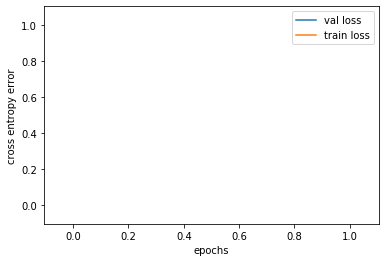

In [39]:
min_entries = min(len(training_losses), len(validation_losses))
epochs_plots = []
for i in range(min_entries):
    epochs_plots.append(i+1)
    
val_plots = training_losses[:min_entries]
train_plots = validation_losses[:min_entries]

plt.figure()
plt.plot(epochs_plots, val_plots, label='val loss')
plt.plot(epochs_plots, train_plots, label='train loss')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('cross entropy error')